In [33]:
import os
import sys

PATH_FLOD = os.path.join(os.getcwd(), '..')

sys.path.append(os.path.abspath(PATH_FLOD))
from experiments.experiments import get_datasets, get_dataset_from_path

In [34]:
X, y = get_dataset_from_path(get_datasets()['breast-cancer'])

/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprec

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X = PCA(n_components=2).fit_transform(X)

X = MinMaxScaler().fit_transform(X)

In [36]:
def split_by_class(X, y):
    X_normal, X_outlier = np.empty(shape=(0,2)), np.empty(shape=(0,2))
    for i, row in enumerate(X):
        r = np.atleast_2d(row)

        if y[i] == 1:
            X_normal = np.concatenate([X_normal, r])
        else:
            X_outlier = np.concatenate([X_outlier, r])

    return X_normal, X_outlier

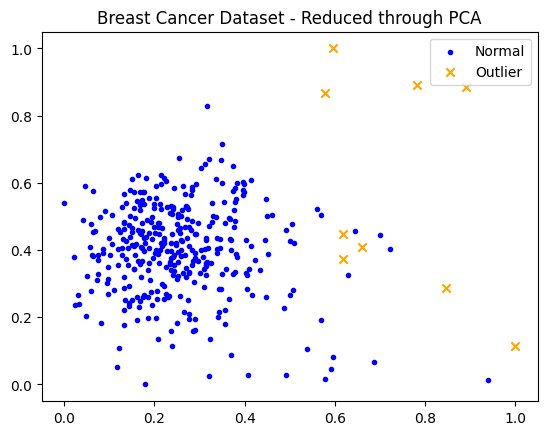

In [37]:
# Plot dataset in due dimensioni evidenziando le anomalie
import matplotlib.pyplot as plt
import numpy as np

plt.title('Breast Cancer Dataset - Reduced through PCA')

X_normal, X_outlier = split_by_class(X, y)

plt.scatter(X_normal[:, 0], X_normal[:, 1], label='Normal', marker='.', color='blue')
plt.scatter(X_outlier[:, 0], X_outlier[:, 1], label='Outlier', marker='x', color='orange')
plt.legend()
plt.show()

/Users/maxfrax/opt/anaconda3/envs/flod/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


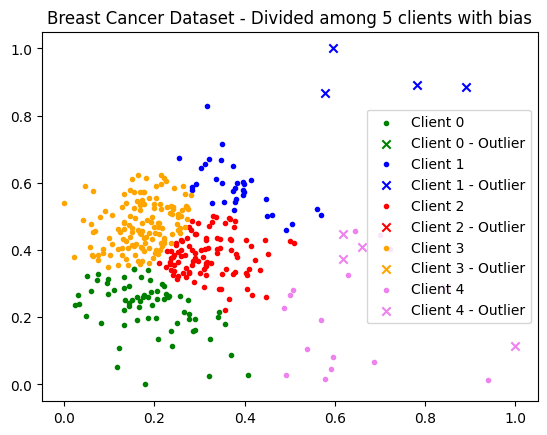

In [38]:
# Plot dataset in due dimensioni evidenziando le anomalie e l'assegnamento ai vari client
# Usare due features sensibili
# Un esempio IID e uno biased
from sklearn.cluster import KMeans

cluster_assignment = KMeans(n_clusters=5).fit_predict(X)

color = ['green', 'blue', 'red', 'orange', 'violet']

clients = [np.empty(shape=(0,2)) for i in range(5)]
cy = [[] for i in range(5)]

for i, row in enumerate(X):
    r = np.atleast_2d(row)

    cluster = cluster_assignment[i]
    clients[cluster] = np.concatenate([clients[cluster], r])
    
    cy[cluster].append(y[i])

plt.title('Breast Cancer Dataset - Divided among 5 clients with bias')
for i, c in enumerate(clients):
    c_normal, c_outlier = split_by_class(c, cy[i])
    plt.scatter(c_normal[:, 0], c_normal[:, 1], label=f'Client {i}', color= color[i], marker='.')
    plt.scatter(c_outlier[:, 0], c_outlier[:, 1], label=f'Client {i} - Outlier', marker='x', color= color[i])
plt.legend()
plt.show()

In [39]:
from flod.classifiers.bsvclassifier import BSVClassifier
from flod.classifiers.dp_flbsv import DPFLBSV

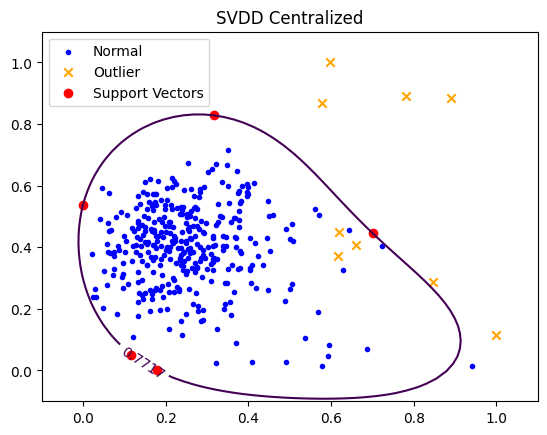

In [40]:
# Togliere da plot precedente l'assegnamento ai client e plottare SVDD centralizzato deve evidenziare sv
plt.title('SVDD Centralized')

X_normal, X_outlier = split_by_class(X, y)

C, q = .3, 3

clf = BSVClassifier(c=C, q=q, normal_class_label=1, outlier_class_label=-1).fit(X, y)

offset = 0.1

gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
levels = [clf._best_radius()]
membership_contour = plt.contour(gX, gY, gZ, levels=levels)
plt.clabel(membership_contour, inline=1)

sv = clf.get_support_vectors()

plt.scatter(X_normal[:, 0], X_normal[:, 1], label='Normal', marker='.', color='blue')
plt.scatter(X_outlier[:, 0], X_outlier[:, 1], label='Outlier', marker='x', color='orange')
plt.scatter(sv[:, 0], sv[:, 1], label='Support Vectors', marker='o', color='red', alpha=1)
plt.legend()
plt.show()

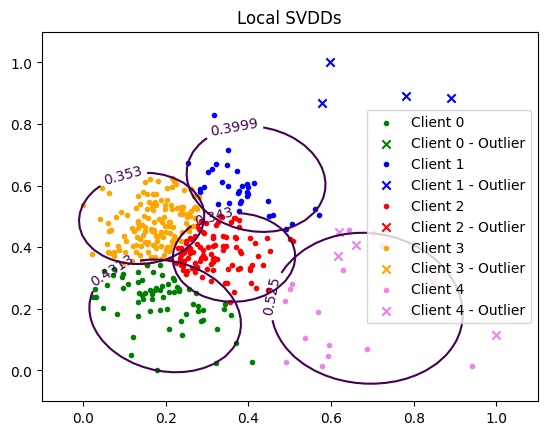

In [41]:
# Plot con client assignment
# Plot local SVDD deve evidenziare sv
plt.title('Local SVDDs')
for i, c in enumerate(clients):
    c_normal, c_outlier = split_by_class(c, cy[i])
    plt.scatter(c_normal[:, 0], c_normal[:, 1], label=f'Client {i}', color= color[i], marker='.')
    plt.scatter(c_outlier[:, 0], c_outlier[:, 1], label=f'Client {i} - Outlier', marker='x', color= color[i])

    clf = BSVClassifier(c=C, q=q, normal_class_label=1, outlier_class_label=-1).fit(c, cy[i])

    gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
    gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array([clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
    gZ = zs.reshape(gX.shape)
    levels = [clf._best_radius()]
    membership_contour = plt.contour(gX, gY, gZ, levels=levels)
    plt.clabel(membership_contour, inline=1)

    #sv = clf.get_support_vectors()
    #plt.scatter(sv[:, 0], sv[:, 1], label=f'Support Vectors {i}', marker='o', color='red', alpha=1)


plt.legend()
plt.show()

In [42]:
MAX_ROUNDS = 1
NOISE = 1
TOL = 0.01

C, q = 0.4, 5

sve = DPFLBSV(NOISE, TOL, normal_class_label=1, outlier_class_label=-1, max_rounds=MAX_ROUNDS, C = C, q = q, total_clients=5)

sve.fit(X, y, client_assignment=cluster_assignment, round_callback=None)

FederatedBSVClassifier is not designed to train with outliers. All outliers will be ignored


DPFLBSV(C=0.4, noise=1, normal_class_label=1, outlier_class_label=-1, q=5,
        tol=0.01, total_clients=5)

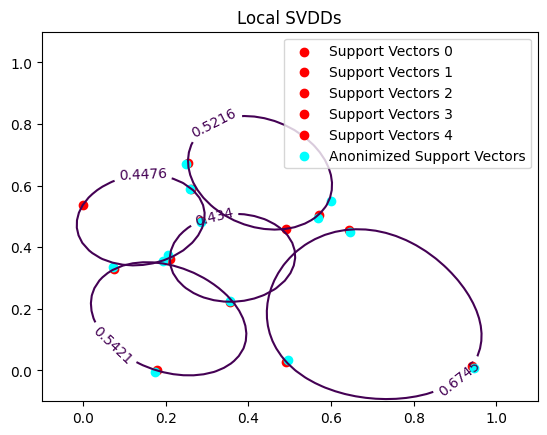

In [43]:
# Zoom in su un SV e plottare generazione sintetica di sostituto
plt.title('Local SVDDs')
for i, c in enumerate(clients):
    c_normal, c_outlier = split_by_class(c, cy[i])

    clf = BSVClassifier(c=C, q=q, normal_class_label=1, outlier_class_label=-1).fit(c, cy[i])

    gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
    gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array([clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
    gZ = zs.reshape(gX.shape)
    levels = [clf._best_radius()]
    membership_contour = plt.contour(gX, gY, gZ, levels=levels)
    plt.clabel(membership_contour, inline=1)

    sv = clf.get_support_vectors()
    plt.scatter(sv[:, 0], sv[:, 1], label=f'Support Vectors {i}', marker='o', color='red')


plt.scatter(sve.all_support_vectors[:, 0], sve.all_support_vectors[:, 1], label=f'Anonimized Support Vectors', marker='o', color='cyan')
plt.legend()
plt.show()

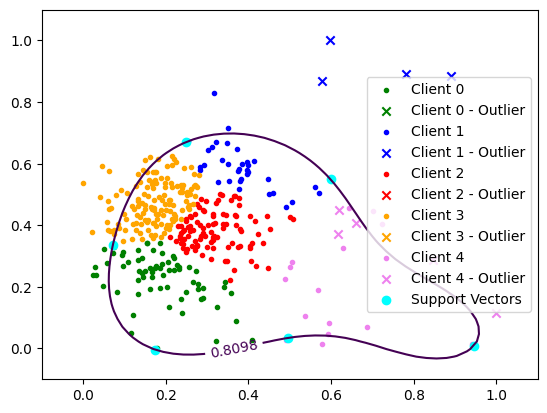

In [44]:
# plot local SVDD di SVE ma con nuovi punti sintetici
gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([sve.clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
zs = np.array([sve.clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
levels = [sve.clf._best_radius()]
membership_contour = plt.contour(gX, gY, gZ, levels=levels)
plt.clabel(membership_contour, inline=1)

for i, c in enumerate(clients):
    c_normal, c_outlier = split_by_class(c, cy[i])
    plt.scatter(c_normal[:, 0], c_normal[:, 1], label=f'Client {i}', color= color[i], marker='.')
    plt.scatter(c_outlier[:, 0], c_outlier[:, 1], label=f'Client {i} - Outlier', marker='x', color= color[i])

sv = sve.model['xs']

plt.scatter(sv[:, 0], sv[:, 1], label='Support Vectors', marker='o', color='cyan', alpha=1)
plt.legend()
plt.show()

In [45]:
from flod.classifiers.ensemble_flbsv import EnsembleFLBSV

In [46]:
esvdd = EnsembleFLBSV(privacy=True, normal_class_label=1, outlier_class_label=-1, C = C, q = q, total_clients=5)
esvdd.fit(X, y, client_assignment=cluster_assignment, round_callback=None)

FederatedBSVClassifier is not designed to train with outliers. All outliers will be ignored


EnsembleFLBSV(C=0.4, normal_class_label=1, outlier_class_label=-1, privacy=True,
              q=5, total_clients=5)

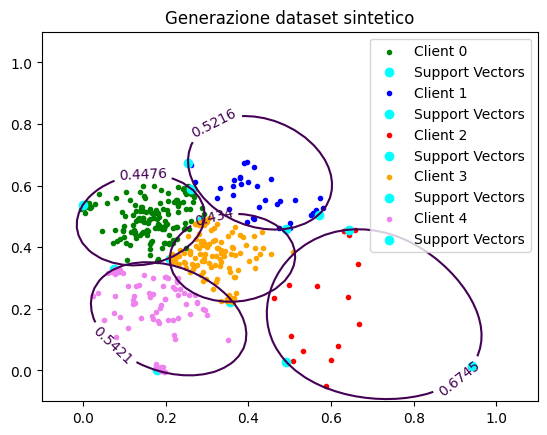

In [47]:
# ENSEMBLE SVDD riparte da LOCAL SVDD
old_sv = []

# Plot generazione dataset sintetico
plt.title('Generazione dataset sintetico')
for i, c in enumerate(clients):
    synth = esvdd.model[i].X_train_
    plt.scatter(synth[:, 0], synth[:, 1], label=f'Client {i}', color= color[i], marker='.')

    clf = BSVClassifier(c=C, q=q, normal_class_label=1, outlier_class_label=-1).fit(c, cy[i])

    gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
    gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array([clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
    gZ = zs.reshape(gX.shape)
    levels = [clf._best_radius()]
    membership_contour = plt.contour(gX, gY, gZ, levels=levels)
    plt.clabel(membership_contour, inline=1)

    sv = clf.get_support_vectors()
    old_sv.append(sv)

    plt.scatter(sv[:, 0], sv[:, 1], label='Support Vectors', marker='o', color='cyan', alpha=1)


plt.legend()
plt.show()

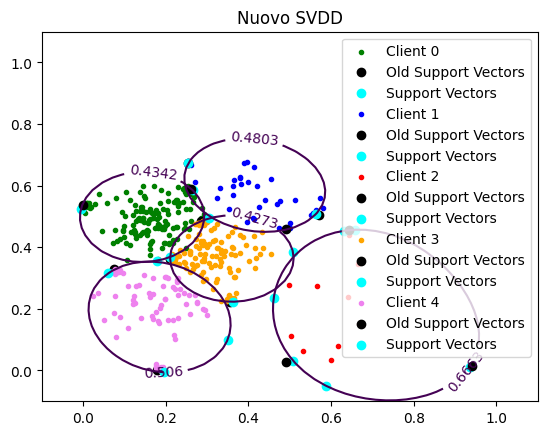

In [48]:
# plot nuovi SVDD
plt.title('Nuovo SVDD')
for i, c in enumerate(clients):
    synth = esvdd.model[i].X_train_
    plt.scatter(synth[:, 0], synth[:, 1], label=f'Client {i}', color= color[i], marker='.')

    clf = esvdd.model[i]

    gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
    gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array([clf._compute_r((x,y)) for x, y in zip(np.ravel(gX), np.ravel(gY))])
    gZ = zs.reshape(gX.shape)
    levels = [clf._best_radius()]
    membership_contour = plt.contour(gX, gY, gZ, levels=levels)
    plt.clabel(membership_contour, inline=1)

    sv = clf.get_support_vectors()
    osv = old_sv[i]

    plt.scatter(osv[:, 0], osv[:, 1], label='Old Support Vectors', marker='o', color='black', alpha=1)
    plt.scatter(sv[:, 0], sv[:, 1], label='Support Vectors', marker='o', color='cyan', alpha=1)

plt.legend()
plt.show()

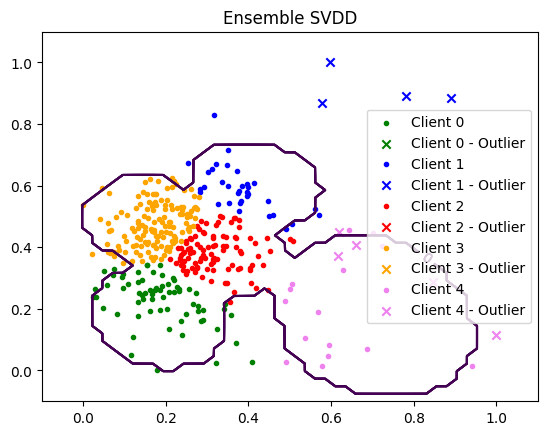

In [49]:
# plot esvdd finale
plt.title('Ensemble SVDD')
for i, c in enumerate(clients):
    c_normal, c_outlier = split_by_class(c, cy[i])
    plt.scatter(c_normal[:, 0], c_normal[:, 1], label=f'Client {i}', color= color[i], marker='.')
    plt.scatter(c_outlier[:, 0], c_outlier[:, 1], label=f'Client {i} - Outlier', marker='x', color= color[i])
    #TODO plot or filter outliers sintetici

    gx = np.linspace(min(X[:,0])-offset, max(X[:,0])+offset)
    gy = np.linspace(min(X[:,1])-offset, max(X[:,1])+offset)
    gX, gY = np.meshgrid(gx, gy)
    zs = np.array(esvdd.score_samples(list(zip(np.ravel(gX), np.ravel(gY)))))
    gZ = zs.reshape(gX.shape)
    levels = [-0]
    membership_contour = plt.contour(gX, gY, gZ, levels=levels)
    plt.clabel(membership_contour, inline=1)


plt.legend()
plt.show()